## Continuous-time Noisy Voter Model (CNVM)

This package provides a fast implementation of the CNVM, which is a dynamical system on a network of $N$ nodes (agents).
Each node is endowed with one of $M$ discrete opinions. Thus, the system state is given by a vector $x \in \{1,\dots,M\}^N$, where $x_i$ describes the opinion of node $i$.
The system state $x$ changes over time as follows:
- Each agent $i$ is influenced by one of its neighbors at a constant rate $r_0\geq 0$ (Poisson process).
- The neighbor is chosen uniformly at random from all neighbors of node $i$ on the network. After being influenced, agent $i$ switches to the neighbor's opinion $n$ with probability $p_{m,n} \in [0,1]$, where $m$ is agent $i$'s current opinion.
- Additionaly, agent $i$ spontaneously thinks about changing his opinion at a cosntant rate $\tilde{r_0}$, independently of its neighborhood. If this event is triggered, the agent $i$ chooses one of the $M$ opinions at random, and switches to it with probability $\tilde{p}_{m,n} \in [0,1]$, where $m$ is agent $i$'s current opinion and $n$ the new opinion.

All in all, the rate at which agent $i$ switches its opinion from $m$ to $n$ is given by
$$ r_0 q(i,n) p_{m,n} + \tilde{r_0} \frac{1}{M} \tilde{p}_{m,n}, $$
where $q(i,n)$ denotes the fraction of nodes with opinion $n$ in the neighborhood of agent $i$.

Alternatively, by defining $r_{m,n} := r_0 p_{m,n}$ and $\tilde{r}_{m,n} := \tilde{r_0} \frac{1}{M} \tilde{p}_{m,n}$, we obtain the total rate
$$ r_{m,n} q(i,n) + \tilde{r}_{m,n}.$$

Let us conduct an example simulation of the CNVM. We begin by doing the necessary imports:

In [5]:
# tell python where to find the cnvm package
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# imports
import cnvm
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

In this example, we will have $N=100$ agents and $M=3$ different opinions. Furthermore, we set $r_0 = 1$ and $\tilde{r}_0 = 0.01$. The probabilities $p_{m,n}$ and $\tilde{p}_{m,n}$ of adopting a new opinion have to be specified for each pair $m\neq n$ and are thus defined as $M \times M$ arrays.

In [6]:
num_agents = 100
num_opinions = 3

r_imit = 1
r_noise = 0.01
prob_imit=np.array([[0, .8, .2],
                    [.2, 0, .8],
                    [.8, .2, 0]])
prob_noise = np.array([[0, .9, .7],
                       [.7, 0, .9],
                       [.9, .7, 0]])

Now we specify the network structure using the networkx class Graph. In this example, we sample a random graph using the Erdös-Renyi model.

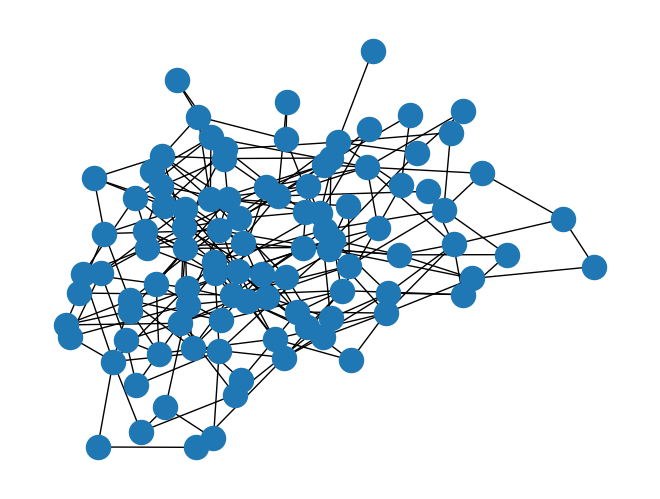

In [8]:
network = nx.erdos_renyi_graph(num_agents, p=0.05)
nx.draw(network)
plt.show()

We summarize all these parameters in the class Parameters.

In [9]:
params = cnvm.parameters.Parameters(num_opinions=num_opinions,
                                    network=network,
                                    r_imit=r_imit,
                                    r_noise=r_noise,
                                    prob_imit=prob_imit,
                                    prob_noise=prob_noise)

The CNVM class, which we will discuss later, accepts the parameters defined above. If you prefer to give the alternative description $r_{m,n}$ and $\tilde{r}_{m,n}$ instead, you can convert the parameters using the following functions:

In [20]:
r, tilde_r = cnvm.parameters.convert_rate_from_cnvm(params)
print(f"r = \n{r}")
print(f"tilde_r =\n{tilde_r}")
print()
r_imit, r_noise, prob_imit, prob_noise = cnvm.parameters.convert_rate_to_cnvm(r, tilde_r)
print(f"r_imit =\n{r_imit}")
print(f"prob_imit =\n{prob_imit}")

r = 
[[0.  0.8 0.2]
 [0.2 0.  0.8]
 [0.8 0.2 0. ]]
tilde_r =
[[0.         0.003      0.00233333]
 [0.00233333 0.         0.003     ]
 [0.003      0.00233333 0.        ]]

r_imit =
0.8
prob_imit =
[[0.   1.   0.25]
 [0.25 0.   1.  ]
 [1.   0.25 0.  ]]


Note that, after converting our original parameters to the alternate description and back, they have changed. The code has optimized our original parameters such that the probabilities $p_{m,n}$ are as large as possible in order to reduce the number of Poisson events without effect.

Now we define the model and the parameters for a single simulation, e.g., the initial state and how long the simulation should be. We execute the simulation by calling model.simulate.

In [24]:
model = cnvm.CNVM(params)

x_init = np.concatenate([0 * np.ones(int(20 * num_agents / 100)),
                         1 * np.ones(int(50 * num_agents / 100)),
                         2 * np.ones(int(30 * num_agents / 100))])
t_max = 200
t, x = model.simulate(t_max, x_init=x_init)
print(t.shape)
print(x.shape)

(20216,)
(20216, 100)


In order to visualize the results of the simulation, we calculate an aggregate state called the opinion shares. The opinion shares are simply the numbers of agents of each discrete opinion. For example, in our initial state we had 20 agents with opinion 0, 50 with opinion 1, and 30 with opinion 2.

In [27]:
from cnvm.collective_variables import OpinionShares
opinion_shares = OpinionShares(num_opinions=num_opinions)
c = opinion_shares(x)
print(c.shape)

(20216, 3)


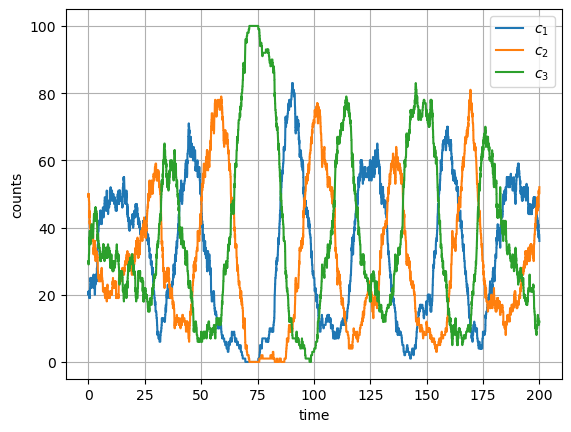

In [28]:
for i in range(c.shape[1]):
    plt.plot(t, c[:, i], label=f"$c_{i+1}$")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("counts")
plt.show()

It is often required to perform many simulations for many initial states to approximate important statistics. The package provides a utility function for that purpose:

In [39]:
from cnvm.utils import sample_many_runs

initial_states = np.array([x_init])
t, c = sample_many_runs(params, initial_states, t_max, num_timesteps=200, num_runs=1000, collective_variable=opinion_shares)
print(t.shape)
print(c.shape)

(200,)
(1, 1000, 200, 3)


The output c has the shape (# initial states, # samples, # timesteps, # opinions). We plot the ensemble average:

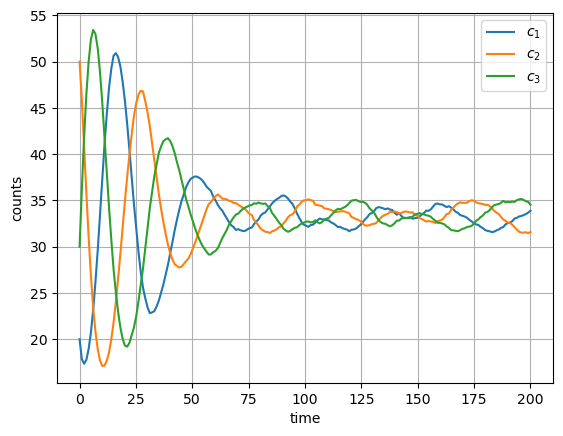

In [40]:
for i in range(c.shape[3]):
    plt.plot(t, np.mean(c[0, :, :, i], axis=0), label=f"$c_{i+1}$")
plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("counts")
plt.show()